### Random Forest Model

We now try a Random Forest Classifier to improve the accuracy of our estimates. We use a limited set of hyper parameters with a GridSearchCV on a sample of the data, and use the entire available dataset after selecting the most promising of these parameters. We also only use Gini as a measure of impurity to make computation easier.

Ideally, this will limit any overfitting in the model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_precision_recall_curve

In [17]:
df = pd.read_csv('clean.csv')

In [18]:
weight = sum(df['target'] == 0) / df.shape[0]
df['sample_weight'] = df['target'].apply(lambda x: weight if x == 1 else 1 - weight)
sample = df.sample(n=350000, random_state=0, weights='sample_weight', axis=0)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(sample.drop(['target', 'sample_weight'], axis=1), sample['target'], test_size = .2, random_state=0)

In [20]:
parameters_sample = {'random_state':[0],
              'n_estimators':[100, 1000],
              'max_depth':[3, 5],
              'criterion':['gini']}

grid_sample = GridSearchCV(RandomForestClassifier(),
                      parameters_sample,
                      scoring = ['balanced_accuracy', 'recall', 'precision'],
                      cv=10, refit='balanced_accuracy', n_jobs = -1,verbose=2)

y_train_sample_array = np.array(y_train).reshape(-1)

grid_sample.fit(x_train, y_train_sample_array)

results_sample = pd.DataFrame.from_dict(grid_sample.cv_results_)
results_sample[['params','mean_test_balanced_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 24.8min finished


,params,mean_test_balanced_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.557580,0.928868,0.593762
1,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.559082,0.922074,0.594912
2,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.572088,0.883535,0.604756
3,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.573061,0.880602,0.605543


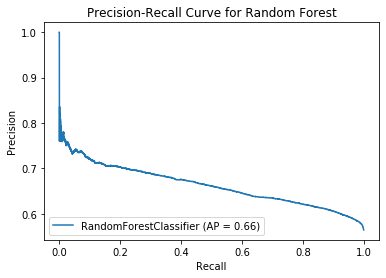

In [24]:
plot_precision_recall_curve(grid_sample.best_estimator_, x_test, y_test)
plt.title('Precision-Recall Curve for Random Forest')
plt.savefig('roc_rf.png')
plt.show()

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, grid_sample.best_estimator_.predict(x_test)).ravel()

In [27]:
print('tn:', tn, 'fp:',fp,'fn:',fn,'tp:',tp)

tn: 8203 fp: 22305 fn: 4664 tp: 34828


In [32]:
probabilities = pd.DataFrame(grid_sample.best_estimator_.predict_proba(x_test)[:,1])
probabilities.columns = ['scored']
probabilities['class'] = 0
thresholds = [.01,.05,.1,.2,.5,1]
scores = []

#mark
for i in thresholds:
    max_val = probabilities.shape[0]
    to_return = int((max_val * i))
    index_nums = probabilities.nlargest(to_return, columns = 'scored').index
    for j in index_nums:
        probabilities.iloc[j,1] = 1
    
    p = precision_score(y_test, probabilities['class'])
    r = recall_score(y_test, probabilities['class'])
    scores.append([i,p,r])
    
fixed_values = pd.DataFrame(scores)
fixed_values.columns = ['threshold', 'precision','recall']
fixed_values.head(6)



,threshold,precision,recall
0,0.01,0.780000,0.013826
1,0.05,0.735143,0.065152
2,0.10,0.712571,0.126304
3,0.20,0.696214,0.246809
4,0.50,0.649714,0.575813
5,1.00,0.564171,1.000000


In [34]:
balanced_accuracy_score(y_test, grid_sample.best_estimator_.predict(x_test))

0.5753902126828474